### 16 Jan 2023

# Fig. 8 code.

Manual inspection of clear MODIS data (where surface features are identificable -- meaning minimal cloud cover) is required here. Then, we need to identify when those selected days (clear days) coincide with days where we have seal data so that we can perform a comparision in sea surface temperature from both datasets. These two steps have been done already and in this notebook, we extract the MODIS-derived surface tempearture at the location of seal dives so that we can then compare the two at the same time and location.

In [1]:
# load packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from pyhdf.SD import SD, SDC
from matplotlib.ticker import StrMethodFormatter

## 2014

### 1. Read 2014 seal data
Instead to repeating code from earlier figs, read in saved pickle files of the subsetted seal data from fig. 7 script (which are saved to working directory).

In [2]:
# read pickle files by month and by warm (w) /cool (c) profiles
may14w = pd.read_pickle('may14w_file')
may14c = pd.read_pickle('may14c_file')

june14w = pd.read_pickle('june14w_file')
june14c = pd.read_pickle('june14c_file')

july14w = pd.read_pickle('july14w_file')
july14c = pd.read_pickle('july14c_file')

aug14w = pd.read_pickle('aug14w_file')
aug14c = pd.read_pickle('aug14c_file')

### 2. Define functions to extract MODIS temp at location of seal dive and then compile the results in a numpy array

In [3]:
def extract_T(modislat,modislon,seallat,seallon,thresh = None,method = 'closest'): #var w = go at the end, put thresh in fct 
    
    '''Function to extract T from MODIS thermal image that correlates to lat, lon of seal-borne data.
    Closest Method: Code inspired from: https://kbkb-wx-python.blogspot.com/2016/08/find-nearest-latitude-and-longitude.html.
    Threshold and Closest Methods: Help from Dr. Tasha Snow'''
    
    #Find the absolute value of the difference between the seals lat/lon with every point in the modis grid. 
    #This tells us how close a point is to the particular latitude and longitude.

    abslat = np.abs(modislat-seallat)
    abslon= np.abs(modislon-seallon)

    # calc distance b/w seal and modis for every modis grid point (this is matrix of distances)
    dist = np.sqrt(abslat**2 + abslon**2) #deg
    
    # finds index for smallest distance in the grid
    #latlon_idx = np.argmin(c) # flattens, makes 1D, faster to search this way. can also search for more pixels
    latlon_idx = np.argmin(dist)

    # Unit conversion for method 2
    # convert lat, lon to radians
    modislat_rad = np.radians(modislat)
    modislon_rad = np.radians(modislon)
    seallat_rad = np.radians(seallat)
    seallon_rad = np.radians(seallon)

    # haversine dist calc
    a = np.sin((seallat_rad-modislat_rad)/2.0)**2 + \
        np.cos(modislat_rad) * np.cos(seallat_rad) * np.sin((seallon_rad-modislon_rad)/2.0)**2

    # calc dist in km for method 2
    earth_radius = 6371 #km
    distkm = earth_radius * 2 * np.arcsin(np.sqrt(a)) #km
    
    # Two different methods to extract temp:
    
    # Threshold -- search for modis pixel with warmest T in distance thresh
    # This method may be most suitable here as modis pixels are 4 km and can contain both sea ice/ocean/part of the ice front
    if method == 'threshold':
        # find max(dist where dist is less than threshold)
        thresh = 6 # km
        #var = [B31[distkm<thresh].mean(), B31[distkm<thresh].std(), (np.abs(B31[distkm<thresh].max() - B31[distkm<thresh].min()))] #print variability: mean, std, range within search radius
        var = B31[distkm<thresh].std()
        grid_temp = B31[distkm<thresh].max()
        
        return grid_temp,var
        #return grid_temp

    # Closest -- search modis pixel that is closest to seal location and extract T
    elif method == 'closest':

        # finds index for smallest distance in the grid
        #latlon_idx = np.argmin(c) # flattens, makes 1D, faster to search this way. can also search for more pixels
        latlon_idx = np.argmin(dist)

        # search for T :
        grid_temp = B31.flat[latlon_idx] 
        
        return grid_temp

In [4]:
def compileTs(modislat,modislon,seallocation,date):    
    
    '''Function compiles extracted T from modis with corresponding 
    seal-borne T from same location and returns a numpy array where
    
    left col = seal-borne T
    right col = modis T
    
    for same date and location.'''

    # call fct in loop to get T at every coord pair
    Tmodis = []
    variability = []
    #for i in sealloc:
    for i in seallocation:

        # With two method fct
        Temp = extract_T(modislat,modislon,i[0],i[1],thresh = None,method = 'threshold')
        Tmodis.append(Temp[0]) 
        variability.append(Temp[1])

    #reset index of seal T to call CT, might need to (un)comment this if error arises
    date = date.reset_index()

    Tseal = []
    for i in date['CT']:

        Tseal.append(i)
    
    #returns 2 array: one with [Tmodis, Tseal], one with [meanT, stdT] within distance threshold
    return(np.array([Tmodis, Tseal, variability]).T)

### 3. Run these functions on the data

### 2014

In [5]:
# August 6 (MYD ,julian date 218) - WARM

# isolate aug6
warmaug6_2014 = aug14w[(aug14w['z']==0.0)]
warmaug6_2014 = warmaug6_2014[warmaug6_2014['Datetime'].dt.strftime('%Y-%m-%d') == '2014-08-06']

# define lat, lon
MODfiles = glob('../MODIS/2014/MYD09.A2014218*')  # Aqua
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
lataug6 = mod09.select('Latitude')[:]
lonaug6 = mod09.select('Longitude')[:]

# define sealloc array
seallocaug6 = warmaug6_2014[['LATITUDE','LONGITUDE']].values

# call fct
Tcompaug6 = compileTs(lataug6,lonaug6,seallocaug6,warmaug6_2014)
Tcompaug6

array([[-2.98      , -1.23905478,  0.32374119],
       [-3.67      , -1.41995153,  5.68702697]])

In [6]:
# August 6 (MYD ,julian date 218) - COOL

# isolate aug6
coolaug6_2014 = aug14c[(aug14c['z']==0.0)]
coolaug6_2014 = coolaug6_2014[coolaug6_2014['Datetime'].dt.strftime('%Y-%m-%d') == '2014-08-06']

# define lat, lon
MODfiles = glob('../MODIS/2014/MYD09.A2014218*')  # Aqua
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
lataug6 = mod09.select('Latitude')[:]
lonaug6 = mod09.select('Longitude')[:]

# define sealloc array
seallocaug6c = coolaug6_2014[['LATITUDE','LONGITUDE']].values

# call fct
Tcompaug6c = compileTs(lataug6,lonaug6,seallocaug6c,coolaug6_2014)
Tcompaug6c

array([[-3.87      , -1.85209662,  5.27759281],
       [-3.78      , -1.84209574,  5.38384422]])

In [7]:
# August 7 (MOD ,julian date 219) - WARM

# isolate 
warmaug7_2014 = aug14w[(aug14w['z']==0.0)]
warmaug7_2014 = warmaug7_2014[warmaug7_2014['Datetime'].dt.strftime('%Y-%m-%d') == '2014-08-07']

# define lat, lon
MODfiles = glob('../MODIS/2014/MOD09.A2014219*') # Terra
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
lataug7 = mod09.select('Latitude')[:]
lonaug7 = mod09.select('Longitude')[:]

# define sealloc array
seallocaug7 = warmaug7_2014[['LATITUDE','LONGITUDE']].values

# call fct
Tcompaug7 = compileTs(lataug7,lonaug7,seallocaug7,warmaug7_2014)
Tcompaug7

array([[-7.47      , -1.51605   ,  5.67247212],
       [-7.47      , -1.50002687,  5.26824283],
       [-7.4       , -1.53305909,  3.64293267]])

In [8]:
# August 7 (MOD ,julian date 219) - COOL

# isolate 
coolaug7_2014 = aug14c[(aug14c['z']==0.0)]
coolaug7_2014 = coolaug7_2014[coolaug7_2014['Datetime'].dt.strftime('%Y-%m-%d') == '2014-08-07']

# define lat, lon
MODfiles = glob('../MODIS/2014/MOD09.A2014219*') # Terra
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
lataug7 = mod09.select('Latitude')[:]
lonaug7 = mod09.select('Longitude')[:]

# define sealloc array
seallocaug7c = coolaug7_2014[['LATITUDE','LONGITUDE']].values

# call fct
Tcompaug7c = compileTs(lataug7,lonaug7,seallocaug7c,coolaug7_2014)
Tcompaug7c

array([[-7.85      , -1.8550993 ,  3.83195082]])

In [9]:
# August 8 (MYD ,julian date 220) -B WARM

# isolate 
warmaug8_2014 = aug14w[(aug14w['z']==0.0)]
warmaug8_2014 = warmaug8_2014[warmaug8_2014['Datetime'].dt.strftime('%Y-%m-%d') == '2014-08-08']

# define lat, lon
MODfiles = glob('../MODIS/2014/MYD09.A2014220*') # Aqua
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
lataug8 = mod09.select('Latitude')[:]
lonaug8 = mod09.select('Longitude')[:]

# define sealloc array
seallocaug8 = warmaug8_2014[['LATITUDE','LONGITUDE']].values

# call fct
Tcompaug8 = compileTs(lataug8,lonaug8,seallocaug8,warmaug8_2014)
Tcompaug8

array([[-4.61      , -1.30802413,  2.80602082]])

In [10]:
# August 8 (MYD ,julian date 220) - COOL

# isolate 
coolaug8_2014 = aug14c[(aug14c['z']==0.0)]
coolaug8_2014 = coolaug8_2014[coolaug8_2014['Datetime'].dt.strftime('%Y-%m-%d') == '2014-08-08']

# define lat, lon
MODfiles = glob('../MODIS/2014/MYD09.A2014220*') # Aqua
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
lataug8c = mod09.select('Latitude')[:]
lonaug8c = mod09.select('Longitude')[:]

# define sealloc array
seallocaug8c = coolaug8_2014[['LATITUDE','LONGITUDE']].values

# call fct
Tcompaug8c = compileTs(lataug8,lonaug8,seallocaug8c,coolaug8_2014)
Tcompaug8c

array([[-3.67      , -1.84816268,  3.37465777],
       [-4.43      , -1.84616002,  2.79523565]])

In [11]:
# August 19 (MOD ,julian date 231) - WARM

# isolate 
warmaug19_2014 = aug14w[(aug14w['z']==0.0)]
warmaug19_2014 = warmaug19_2014[warmaug19_2014['Datetime'].dt.strftime('%Y-%m-%d') == '2014-08-19']

# define lat, lon
MODfiles = glob('../MODIS/2014/MOD09.A2014231*') # Terra
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
lataug19 = mod09.select('Latitude')[:]
lonaug19 = mod09.select('Longitude')[:]

# define sealloc array
seallocaug19 = warmaug19_2014[['LATITUDE','LONGITUDE']].values

# call fct
Tcompaug19 = compileTs(lataug19,lonaug19,seallocaug19,warmaug19_2014)
Tcompaug19

array([[-17.22      ,  -1.36202185,   3.65852482],
       [-15.95      ,  -1.22696719,   4.92471296]])

In [12]:
# August 19 (MOD ,julian date 231) - COOL

# isolate 
coolaug19_2014 = aug14c[(aug14c['z']==0.0)]
coolaug19_2014 = coolaug19_2014[coolaug19_2014['Datetime'].dt.strftime('%Y-%m-%d') == '2014-08-19']

# define lat, lon
MODfiles = glob('../MODIS/2014/MOD09.A2014231*') # Terra
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
lataug19 = mod09.select('Latitude')[:]
lonaug19 = mod09.select('Longitude')[:]

# define sealloc array
seallocaug19c = coolaug19_2014[['LATITUDE','LONGITUDE']].values

# call fct
Tcompaug19c = compileTs(lataug19,lonaug19,seallocaug19c,coolaug19_2014)
Tcompaug19c

# None

array([], shape=(0, 3), dtype=float64)

In [13]:
# July 16 (MYD ,julian date 197) - WARM

# isolate 
warmjul16_2014 = july14w[(july14w['z']==0.0)]
warmjul16_2014 = warmjul16_2014[warmjul16_2014['Datetime'].dt.strftime('%Y-%m-%d') == '2014-07-16']

# define lat, lon
MODfiles = glob('../MODIS/2014/MOD09.A2014197*') # Terra
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjul16 = mod09.select('Latitude')[:]
lonjul16 = mod09.select('Longitude')[:]

# define sealloc array
seallocjul16 = warmjul16_2014[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjul16 = compileTs(latjul16,lonjul16,seallocjul16,warmjul16_2014)
Tcompjul16

array([[-21.48      ,  -1.31102261,   2.55199111],
       [-10.35      ,  -1.34103691,   2.53916609],
       [-14.61      ,  -0.97792989,   5.0288631 ]])

In [14]:
# July 16 (MYD ,julian date 197) - COOL

# isolate 
cooljul16_2014 = july14c[(july14c['z']==0.0)]
cooljul16_2014 = cooljul16_2014[cooljul16_2014['Datetime'].dt.strftime('%Y-%m-%d') == '2014-07-16']

# define lat, lon
MODfiles = glob('../MODIS/2014/MOD09.A2014197*') # Terra
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjul16 = mod09.select('Latitude')[:]
lonjul16 = mod09.select('Longitude')[:]

# define sealloc array
seallocjul16c = cooljul16_2014[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjul16c = compileTs(latjul16,lonjul16,seallocjul16c,cooljul16_2014)
Tcompjul16c

array([[-14.61      ,  -1.53004504,   4.87917764],
       [-18.91      ,  -1.84529453,   8.95299772],
       [-16.2       ,  -1.83927532,   9.14882652],
       [-14.54      ,  -1.84129739,   9.30362492]])

In [15]:
# May 11 2014 (MYD ,julian date 131) - COOL

# isolate 
coolmay11_2014 = may14c[(may14c['z']==0.0)]
coolmay11_2014 = coolmay11_2014[coolmay11_2014['Datetime'].dt.strftime('%Y-%m-%d') == '2014-05-11']

# define lat, lon
MODfiles = glob('../MODIS/2014/MOD09.A2014131*') # Terra
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay11_2014 = mod09.select('Latitude')[:]
lonmay11_2014 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay11c = coolmay11_2014[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay11c = compileTs(latmay11_2014,lonmay11_2014,seallocmay11c,coolmay11_2014)
Tcompmay11c

array([[-3.97      , -1.82709649,  1.21882288],
       [-4.12      , -1.80909326,  1.12877805],
       [-3.97      , -1.71904208,  1.19094183]])

In [16]:
# June 22 2014 (MYD ,julian date 173) - COOL

# isolate 
cooljune22_2014 = june14c[(june14c['z']==0.0)]
cooljune22_2014 = cooljune22_2014[cooljune22_2014['Datetime'].dt.strftime('%Y-%m-%d') == '2014-06-22']

# define lat, lon
MODfiles = glob('../MODIS/2014/MYD09.A2014173*') # Terra
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjune22_2014 = mod09.select('Latitude')[:]
lonjune22_2014 = mod09.select('Longitude')[:]

# define sealloc array
seallocjune22c = cooljune22_2014[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjune22c = compileTs(latjune22_2014,lonjune22_2014,seallocjune22c,cooljune22_2014)
Tcompjune22c

array([[-11.55      ,  -1.83711936,   0.78047779],
       [ -8.28      ,  -1.85311216,   1.79659197],
       [ -7.93      ,  -1.86312803,   2.37600202],
       [ -6.22      ,  -1.86424179,   7.06560928],
       [ -6.22      ,  -1.85825522,   4.24384028],
       [ -6.22      ,  -1.8602862 ,   7.94785033]])

In [17]:
# July 15 2014 (MYD ,julian date 196) - COOL

# isolate 
cooljuly15_2014 = july14c[(july14c['z']==0.0)]
cooljuly15_2014 = cooljuly15_2014[cooljuly15_2014['Datetime'].dt.strftime('%Y-%m-%d') == '2014-07-15']

# define lat, lon
MODfiles = glob('../MODIS/2014/MYD09.A2014173*') # Terra
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjuly15_2014 = mod09.select('Latitude')[:]
lonjuly15_2014 = mod09.select('Longitude')[:]

# define sealloc array
seallocjuly15c = cooljuly15_2014[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjuly15c = compileTs(latjuly15_2014,lonjuly15_2014,seallocjuly15c,cooljuly15_2014)
Tcompjuly15c

array([[-12.56      ,  -1.83017644,   0.80498722],
       [ -8.28      ,  -1.84820505,   1.38665851],
       [ -7.38      ,  -1.84423244,   0.41137447],
       [ -7.33      ,  -1.83820693,   0.46833648],
       [ -7.05      ,  -1.84320498,   0.46579499],
       [ -6.22      ,  -1.84123363,   8.03448991],
       [ -6.22      ,  -1.8473    ,   8.59405071],
       [ -6.22      ,  -1.84630446,   8.47318761],
       [ -6.22      ,  -1.84630645,   8.28882688]])

In [18]:
# Aug 26 2014 (MOD ,julian date 238) - COOL

# isolate 
coolaug26_2014 = aug14c[(aug14c['z']==0.0)]
coolaug26_2014 = coolaug26_2014[coolaug26_2014['Datetime'].dt.strftime('%Y-%m-%d') == '2014-08-26']

# define lat, lon
MODfiles = glob('../MODIS/2014/MOD09.A2014238*')
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
lataug26_2014 = mod09.select('Latitude')[:]
lonaug26_2014 = mod09.select('Longitude')[:]

# define sealloc array
seallocaug26c = coolaug26_2014[['LATITUDE','LONGITUDE']].values

# call fct
Tcompaug26c = compileTs(lataug26_2014,lonaug26_2014,seallocaug26c,coolaug26_2014)
Tcompaug26c

array([[-18.65      ,  -1.88015186,   2.5967352 ]])

## 2019

### 1. Read 2019 seal data
Instead to repeating code from earlier figs, read in saved pickle files of the subsetted seal data from fig. 7 script (which are saved to working directory).

In [19]:
# read pickle files by month and by warm (w) /cool (c) profiles
may19w = pd.read_pickle('may19w_file')
may19c = pd.read_pickle('may19c_file')

june19w = pd.read_pickle('june19w_file')
june19c = pd.read_pickle('june19c_file')

july19w = pd.read_pickle('july19w_file')
july19c = pd.read_pickle('july19c_file')

aug19w = pd.read_pickle('aug19w_file')
aug19c = pd.read_pickle('aug19c_file')

In [20]:
# May 19 (MOD ,julian date 139) - WARM

# isolate 
warmmay19_2019 = may19w[(may19w['z']==0.0)]
warmmay19_2019 = warmmay19_2019[warmmay19_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-19']

#define lat, lon
MODfiles = glob('../MODIS/2019/MYD09.A2019139*') # Aqua
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay19_2019 = mod09.select('Latitude')[:]
lonmay19_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay19_2019 = warmmay19_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay19_2019 = compileTs(latmay19_2019,lonmay19_2019,seallocmay19_2019,warmmay19_2019)
Tcompmay19_2019

array([[-4.89      , -1.68565375,  6.55498599],
       [-5.09      , -1.48106968, 11.71349703],
       [-4.89      , -1.45504757,  3.67469945]])

In [21]:
# May 19 (MOD ,julian date 139) - COOL

# isolate 
coolmay19_2019 = may19c[(may19c['z']==0.0)]
coolmay19_2019 = coolmay19_2019[coolmay19_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-19']

#define lat, lon
MODfiles = glob('../MODIS/2019/MYD09.A2019139*') # Aqua
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay19_2019 = mod09.select('Latitude')[:]
lonmay19_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay19c_2019 = coolmay19_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay19c_2019 = compileTs(latmay19_2019,lonmay19_2019,seallocmay19c_2019,coolmay19_2019)
Tcompmay19c_2019

array([[-4.89      , -1.70463483,  7.13861212]])

In [22]:
# May 20 (MOD ,julian date 140) - WARM

# isolate 
warmmay20_2019 = may19w[(may19w['z']==0.0)]
warmmay20_2019 = warmmay20_2019[warmmay20_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-20']

#define lat, lon
MODfiles = glob('../MODIS/2019/MOD09.A2019140*') # Terra
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay20_2019 = mod09.select('Latitude')[:]
lonmay20_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay20_2019 = warmmay20_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay20_2019 = compileTs(latmay20_2019,lonmay20_2019,seallocmay20_2019,warmmay20_2019)
Tcompmay20_2019

array([[-8.58      , -1.53117255,  6.32298175]])

In [23]:
# May 20 (MOD ,julian date 140) - COOL

# isolate 
coolmay20_2019 = may19c[(may19c['z']==0.0)]
coolmay20_2019 = coolmay20_2019[coolmay20_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-20']

#define lat, lon
MODfiles = glob('../MODIS/2019/MOD09.A2019140*') # Terra
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay20_2019 = mod09.select('Latitude')[:]
lonmay20_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay20c_2019 = coolmay20_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay20c_2019 = compileTs(latmay20_2019,lonmay20_2019,seallocmay20c_2019,coolmay20_2019)
Tcompmay20c_2019

array([[-9.22      , -1.75649783,  6.42844188],
       [-8.58      , -1.73467464,  5.28614739]])

In [24]:
# May 25 (MOD ,julian date 145) - WARM

# isolate 
warmmay25_2019 = may19w[(may19w['z']==0.0)]
warmmay25_2019 = warmmay25_2019[warmmay25_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-25']

#define lat, lon
MODfiles = glob('../MODIS/2019/MOD09.A2019145*') # Terra
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay25_2019 = mod09.select('Latitude')[:]
lonmay25_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay25_2019 = warmmay25_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay25_2019 = compileTs(latmay25_2019,lonmay25_2019,seallocmay25_2019,warmmay25_2019)
Tcompmay25_2019

array([[-14.55      ,  -1.23155056,   3.79177334],
       [ -4.05      ,  -1.09834732,   8.55845303]])

In [25]:
# May 25 (MOD ,julian date 145) - COOL

# isolate 
coolmay25_2019 = may19c[(may19c['z']==0.0)]
coolmay25_2019 = coolmay25_2019[coolmay25_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-25']

#define lat, lon
MODfiles = glob('../MODIS/2019/MOD09.A2019145*') # Terra
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay25_2019 = mod09.select('Latitude')[:]
lonmay25_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay25c_2019 = coolmay25_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay25c_2019 = compileTs(latmay25_2019,lonmay25_2019,seallocmay25c_2019,coolmay25_2019)
Tcompmay25c_2019

array([[-3.88      , -1.82787146,  0.73522263],
       [-3.97      , -1.8288889 ,  2.61376999]])

In [26]:
# May 27 (MOD ,julian date 147) - COOL

# isolate 
coolmay27_2019 = may19c[(may19c['z']==0.0)]
coolmay27_2019 = coolmay27_2019[coolmay27_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-27']

#define lat, lon
MODfiles = glob('../MODIS/2019/MOD09.A2019147*') # Terra
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay27_2019 = mod09.select('Latitude')[:]
lonmay27_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay27c_2019 = coolmay27_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay27c_2019 = compileTs(latmay27_2019,lonmay27_2019,seallocmay27c_2019,coolmay27_2019)
Tcompmay27c_2019

array([[-25.29      ,  -1.84602506,   1.22027458],
       [-23.48      ,  -1.84507854,   0.74834937],
       [ -3.86      ,  -1.74466761,   6.20136522],
       [ -4.32      ,  -1.71466882,   8.75359776],
       [ -3.83      ,  -1.89204112,   4.71583191],
       [ -3.56      ,  -1.81989895,   8.98008032]])

In [27]:
# June 24 (MYD ,julian date 175) - WARM

# isolate 
warmjune24_2019 = june19w[(june19w['z']==0.0)]
warmjune24_2019 = warmjune24_2019[warmjune24_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-06-24']

#define lat, lon
MODfiles = glob('../MODIS/2019/MYD09.A2019175*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjune24_2019 = mod09.select('Latitude')[:]
lonjune24_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocjune24_2019 = warmjune24_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjune24_2019 = compileTs(latjune24_2019,lonjune24_2019,seallocjune24_2019,warmjune24_2019)
Tcompjune24_2019

array([[-6.06      , -1.48697863,  8.22020633],
       [-6.4       , -1.619303  ,  4.80703658],
       [-7.2       , -0.90988129,  6.04818097]])

In [28]:
# June 24 (MYD ,julian date 175) - COOL

# isolate 
cooljune24_2019 = june19c[(june19c['z']==0.0)]
cooljune24_2019 = cooljune24_2019[cooljune24_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-06-24']

#define lat, lon
MODfiles = glob('../MODIS/2019/MYD09.A2019175*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjune24_2019 = mod09.select('Latitude')[:]
lonjune24_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocjune24c_2019 = cooljune24_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjune24c_2019 = compileTs(latjune24_2019,lonjune24_2019,seallocjune24c_2019,cooljune24_2019)
Tcompjune24c_2019

array([[-7.2       , -1.7525958 ,  5.73583382]])

In [29]:
# June 25 (MOD ,julian date 176) - WARM

# isolate 
warmjune25_2019 = june19w[(june19w['z']==0.0)]
warmjune25_2019 = warmjune25_2019[warmjune25_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-06-25']

#define lat, lon
MODfiles = glob('../MODIS/2019/MOD09.A2019176*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjune25_2019 = mod09.select('Latitude')[:]
lonjune25_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocjune25_2019 = warmjune25_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjune25_2019 = compileTs(latjune25_2019,lonjune25_2019,seallocjune25_2019,warmjune25_2019)
Tcompjune25_2019

array([[-14.39      ,  -1.59926961,   3.8360011 ],
       [-14.39      ,  -0.8304968 ,   4.11262876],
       [-14.44      ,  -1.22254953,   3.76541665]])

In [30]:
# May 10 (MOD ,julian date 131) - WARM -- maybe too much cloud

# isolate 
coolmay10_2019 = may19c[(may19c['z']==0.0)]
coolmay10_2019 = coolmay10_2019[coolmay10_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-10']

#define lat, lon
MODfiles = glob('../MODIS/2019/MYD09.A2019130*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay10_2019 = mod09.select('Latitude')[:]
lonmay10_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay10c_2019 = coolmay10_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay10c_2019 = compileTs(latmay10_2019,lonmay10_2019,seallocmay10c_2019,coolmay10_2019)
Tcompmay10c_2019

array([[-15.        ,  -1.85272784,   0.57533569],
       [ -9.21      ,  -1.84171338,   2.26322001],
       [-13.45      ,  -1.83774781,   0.96092199]])

In [31]:
# May 15 (MOD ,julian date 135) - WARM -- maybe too much cloud

# isolate 
coolmay15_2019 = may19c[(may19c['z']==0.0)]
coolmay15_2019 = coolmay15_2019[coolmay15_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-15']

#define lat, lon
MODfiles = glob('../MODIS/2019/MOD09.A2019135*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay15_2019 = mod09.select('Latitude')[:]
lonmay15_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay15c_2019 = coolmay15_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay15c_2019 = compileTs(latmay15_2019,lonmay15_2019,seallocmay15c_2019,coolmay15_2019)
Tcompmay15c_2019

array([[-20.86      ,  -1.78375066,   1.91475672],
       [-17.43      ,  -1.83280414,   3.03528724],
       [-16.63      ,  -1.83079398,   4.96447865]])

In [32]:
# May 17 (MOD ,julian date 137) - WARM -- maybe too much cloud

# isolate 
coolmay17_2019 = may19c[(may19c['z']==0.0)]
coolmay17_2019 = coolmay17_2019[coolmay17_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-17']

#define lat, lon
MODfiles = glob('../MODIS/2019/MYD09.A2019137*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay17_2019 = mod09.select('Latitude')[:]
lonmay17_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay17c_2019 = coolmay17_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay17c_2019 = compileTs(latmay17_2019,lonmay17_2019,seallocmay17c_2019,coolmay17_2019)
Tcompmay17c_2019

array([[-3.1       , -1.82587276,  0.99172671],
       [-3.48      , -1.83293369,  4.92014372],
       [-7.52      , -1.84678499,  2.81663723]])

In [33]:
# May 18 (MOD ,julian date 138) - WARM -- maybe too much cloud

# isolate 
coolmay18_2019 = may19c[(may19c['z']==0.0)]
coolmay18_2019 = coolmay18_2019[coolmay18_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-18']

#define lat, lon
MODfiles = glob('../MODIS/2019/MYD09.A2019138*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay18_2019 = mod09.select('Latitude')[:]
lonmay18_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay18c_2019 = coolmay18_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay18c_2019 = compileTs(latmay18_2019,lonmay18_2019,seallocmay18c_2019,coolmay18_2019)
Tcompmay18c_2019

array([[-8.71      , -1.83372898,  2.06860231],
       [-8.96      , -1.83984854,  1.2529909 ],
       [-6.36      , -1.8468211 ,  2.11409381],
       [-4.23      , -1.81381553,  5.41184517]])

In [34]:
# May 21 (MOD ,julian date 141) - WARM -- maybe too much cloud

# isolate 
coolmay21_2019 = may19c[(may19c['z']==0.0)]
coolmay21_2019 = coolmay21_2019[coolmay21_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-21']

#define lat, lon
MODfiles = glob('../MODIS/2019/MYD09.A2019141*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay21_2019 = mod09.select('Latitude')[:]
lonmay21_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay21c_2019 = coolmay21_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay21c_2019 = compileTs(latmay21_2019,lonmay21_2019,seallocmay21c_2019,coolmay21_2019)
Tcompmay21c_2019

array([[ -9.09      ,  -1.74575787,   1.73903444],
       [-13.08      ,  -1.8197442 ,   0.7198961 ],
       [-13.08      ,  -1.83378862,   0.66953626],
       [-14.49      ,  -1.83477475,   0.59797615]])

In [35]:
# May 22 (MOD ,julian date 141) - WARM -- maybe too much cloud

# isolate 
coolmay22_2019 = may19c[(may19c['z']==0.0)]
coolmay22_2019 = coolmay22_2019[coolmay22_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-22']

#define lat, lon
MODfiles = glob('../MODIS/2019/MYD09.A2019142*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay22_2019 = mod09.select('Latitude')[:]
lonmay22_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay22c_2019 = coolmay22_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay22c_2019 = compileTs(latmay22_2019,lonmay22_2019,seallocmay22c_2019,coolmay22_2019)
Tcompmay22c_2019

array([[-12.2       ,  -1.78372746,   1.01476059],
       [-12.19      ,  -1.8327946 ,   1.32574548],
       [-15.69      ,  -1.85592056,   1.80963024],
       [-16.34      ,  -1.83786849,   0.305247  ]])

In [36]:
# May 23 (MOD ,julian date 141) - WARM -- maybe too much cloud

# isolate 
coolmay23_2019 = may19c[(may19c['z']==0.0)]
coolmay23_2019 = coolmay23_2019[coolmay23_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-23']

#define lat, lon
MODfiles = glob('../MODIS/2019/MYD09.A2019143*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay23_2019 = mod09.select('Latitude')[:]
lonmay23_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay23c_2019 = coolmay23_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay23c_2019 = compileTs(latmay23_2019,lonmay23_2019,seallocmay23c_2019,coolmay23_2019)
Tcompmay23c_2019

array([[-20.68      ,  -1.81179844,   0.9330246 ],
       [-20.68      ,  -1.79479083,   0.81438877]])

In [37]:
# May 26 (MOD ,julian date 146) - WARM -- maybe too much cloud

# isolate 
coolmay26_2019 = may19c[(may19c['z']==0.0)]
coolmay26_2019 = coolmay26_2019[coolmay26_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-26']

#define lat, lon
MODfiles = glob('../MODIS/2019/MYD09.A2019146*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay26_2019 = mod09.select('Latitude')[:]
lonmay26_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay26c_2019 = coolmay26_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay26c_2019 = compileTs(latmay26_2019,lonmay26_2019,seallocmay26c_2019,coolmay26_2019)
Tcompmay26c_2019

array([[ -5.63      ,  -1.76175881,   4.19786654],
       [-21.27      ,  -1.75874337,   0.2572119 ],
       [-20.82      ,  -1.68662036,   0.20571036],
       [ -5.22      ,  -1.76875012,   4.28717219]])

In [38]:
# May 27 (MOD ,julian date 147) - WARM -- maybe too much cloud

# isolate 
coolmay27_2019 = may19c[(may19c['z']==0.0)]
coolmay27_2019 = coolmay27_2019[coolmay27_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-27']

#define lat, lon
MODfiles = glob('../MODIS/2019/MOD09.A2019147*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay27_2019 = mod09.select('Latitude')[:]
lonmay27_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay27c_2019 = coolmay27_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay27c_2019 = compileTs(latmay27_2019,lonmay27_2019,seallocmay27c_2019,coolmay27_2019)
Tcompmay27c_2019

array([[-25.29      ,  -1.84602506,   1.22027458],
       [-23.48      ,  -1.84507854,   0.74834937],
       [ -3.86      ,  -1.74466761,   6.20136522],
       [ -4.32      ,  -1.71466882,   8.75359776],
       [ -3.83      ,  -1.89204112,   4.71583191],
       [ -3.56      ,  -1.81989895,   8.98008032]])

In [39]:
# June 3 (MOD ,julian date 154) - COOL

# isolate 
cooljune3_2019 = june19c[(june19c['z']==0.0)]
cooljune3_2019 = cooljune3_2019[cooljune3_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-06-03']

#define lat, lon
MODfiles = glob('../MODIS/2019/MOD09.A2019154*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjune3_2019 = mod09.select('Latitude')[:]
lonjune3_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocjune3c_2019 = cooljune3_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjune3c_2019 = compileTs(latjune3_2019,lonjune3_2019,seallocjune3c_2019,cooljune3_2019)
Tcompjune3c_2019

array([[-14.12      ,  -1.83119221,   5.36745739],
       [-14.12      ,  -1.82219582,   3.85874975],
       [-14.11      ,  -1.83119769,   4.35347217],
       [-27.96      ,  -1.83473415,   2.42144377],
       [-14.11      ,  -1.82476387,   6.80623862],
       [-18.7       ,  -1.85278841,   1.78050681]])

In [40]:
# June 24 (MOD ,julian date 175) - COOL

# isolate 
cooljune24_2019 = june19c[(june19c['z']==0.0)]
cooljune24_2019 = cooljune24_2019[cooljune24_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-06-24']

#define lat, lon
MODfiles = glob('../MODIS/2019/MYD09.A2019175*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjune24_2019 = mod09.select('Latitude')[:]
lonjune24_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocjune24c_2019 = cooljune24_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjune24c_2019 = compileTs(latjune24_2019,lonjune24_2019,seallocjune24c_2019,cooljune24_2019)
Tcompjune24c_2019

array([[-7.2       , -1.7525958 ,  5.73583382]])

In [41]:
# July 21 (MYD ,julian date 202) - COOL

# isolate 
cooljuly21_2019 = july19c[(july19c['z']==0.0)]
cooljuly21_2019 = cooljuly21_2019[cooljuly21_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-07-21']

#define lat, lon
MODfiles = glob('../MODIS/2019/MYD09.A2019202*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjuly21_2019 = mod09.select('Latitude')[:]
lonjuly21_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocjuly21c_2019 = cooljuly21_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjuly21c_2019 = compileTs(latjuly21_2019,lonjuly21_2019,seallocjuly21c_2019,cooljuly21_2019)
Tcompjuly21c_2019

array([[-29.7       ,  -1.83719171,   2.52366453],
       [-35.63      ,  -1.83419894,   0.71761519]])

In [42]:
# July 22 (MYD ,julian date 203) - COOL

# isolate 
cooljuly22_2019 = july19c[(july19c['z']==0.0)]
cooljuly22_2019 = cooljuly22_2019[cooljuly22_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-07-22']

#define lat, lon
MODfiles = glob('../MODIS/2019/MYD09.A2019203*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjuly22_2019 = mod09.select('Latitude')[:]
lonjuly22_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocjuly22c_2019 = cooljuly22_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjuly22c_2019 = compileTs(latjuly22_2019,lonjuly22_2019,seallocjuly22c_2019,cooljuly22_2019)
Tcompjuly22c_2019

array([[-44.59      ,  -1.83419894,   0.92997461],
       [-41.49      ,  -1.81615492,   1.32730222],
       [-41.08      ,  -1.83719307,   2.11713174]])

In [43]:
# July 27 (MYD ,julian date 208) - COOL

# isolate 
cooljuly27_2019 = july19c[(july19c['z']==0.0)]
cooljuly27_2019 = cooljuly27_2019[cooljuly27_2019['Datetime'].dt.strftime('%Y-%m-%d') == '2019-07-27']

#define lat, lon
MODfiles = glob('../MODIS/2019/MYD09.A2019208*') 
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjuly27_2019 = mod09.select('Latitude')[:]
lonjuly27_2019 = mod09.select('Longitude')[:]

# define sealloc array
seallocjuly27c_2019 = cooljuly27_2019[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjuly27c_2019 = compileTs(latjuly27_2019,lonjuly27_2019,seallocjuly27c_2019,cooljuly27_2019)
Tcompjuly27c_2019

array([[-19.79      ,  -1.8461992 ,   1.74629158],
       [ -6.34      ,  -1.8502476 ,   8.59242946],
       [ -6.34      ,  -1.85927863,   8.20281512],
       [-10.36      ,  -1.84026088,   5.95050498]])

## 2020

### 1. Read seal data

In [44]:
# # Amundsen seal tag 2014 (some 2006 too)
# seal14_file = '../AmundsenSeal2014.pkl'

# To read from pickle after already created 
seal20 = pd.read_pickle('seal20_file')

### 2. Partition by month and by warm/cool(background) profiles

In [45]:
# T cutoff thresh (defined in fig. 5 script)
# define cool ("background") dives in dataframe within bounding box lat/lon
coolsurf = seal20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-74.9 < LATITUDE < -74 & -104.7 < LONGITUDE < -102 & 0.0 <= z <= 20')
coolsurfMJJA20 = coolsurf[(coolsurf['Datetime']>='2020-5-1') & (coolsurf['Datetime']<'2020-9-1')] # constrain winter months

# calculate temperature treshold at 3std > background surface mean
thresh2020 = coolsurfMJJA20['CT'].mean() + 3*coolsurfMJJA20['CT'].std()

# Cutoff T in deg C
print('2020 threshold:',thresh2020) #CT

2020 threshold: -1.7421517137000042


#### May 2020

In [46]:
# isolate may20 data
may20surf = seal20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
may20surf = may20surf[(may20surf['Datetime']>='2020-5-1') & (may20surf['Datetime']<'2020-6-1')]  # now constraining dates
may20surf = may20surf.reset_index()

# round lat,lon
may20surf['LAT_rounded'] = round(may20surf.iloc[:,3],4)
may20surf['LONG_rounded'] = round(may20surf.iloc[:,4],4)

# Groubpy (on rounded cols)
may20surf = may20surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean'})
may20surf = may20surf.reset_index()
#may20surf.head(5)

# isolate warm profiles based on thresh
may20surfwarm = may20surf[may20surf.iloc[:,5] > thresh2020] #col 5 is CT, wherever CT > cutoff, define as may19surfwarm
may20surfcool = may20surf[may20surf.iloc[:,5] < thresh2020] #same for cool

# add rounded lat long to seal19 so that we have same header and vals
seal20['LAT_rounded'] = round(seal20.iloc[:,0],4)
seal20['LONG_rounded'] = round(seal20.iloc[:,1],4)

# isolate warm profiles w entire depth information
may20w = seal20[seal20['LAT_rounded'].isin(may20surfwarm['LAT_rounded']) & seal20['LONG_rounded'].isin(may20surfwarm['LONG_rounded'])]
may20c = seal20[seal20['LAT_rounded'].isin(may20surfcool['LAT_rounded']) & seal20['LONG_rounded'].isin(may20surfcool['LONG_rounded'])]

#### June 2020

In [47]:
# isolate june20 data
june20surf = seal20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
june20surf = june20surf[(june20surf['Datetime']>='2020-6-1') & (june20surf['Datetime']<'2020-7-1')]  # now constraining dates
june20surf = june20surf.reset_index()

# round lat,lon
june20surf['LAT_rounded'] = round(june20surf.iloc[:,3],4)
june20surf['LONG_rounded'] = round(june20surf.iloc[:,4],4)

# Groubpy (on rounded cols)
june20surf = june20surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean'})
june20surf = june20surf.reset_index()

# isolate warm profiles based on threshold
june20surfwarm = june20surf[june20surf.iloc[:,5] > thresh2020] 
june20surfcool = june20surf[june20surf.iloc[:,5] < thresh2020] 

# add rounded lat long to seal19 so that we have same header and vals
seal20['LAT_rounded'] = round(seal20.iloc[:,0],4)
seal20['LONG_rounded'] = round(seal20.iloc[:,1],4)

# isolate warm profiles w entire depth information
june20w = seal20[seal20['LAT_rounded'].isin(june20surfwarm['LAT_rounded']) & seal20['LONG_rounded'].isin(june20surfwarm['LONG_rounded'])]
june20c = seal20[seal20['LAT_rounded'].isin(june20surfcool['LAT_rounded']) & seal20['LONG_rounded'].isin(june20surfcool['LONG_rounded'])]

#### July 2020

In [48]:
# isolate july20 data
july20surf = seal20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
july20surf = july20surf[(july20surf['Datetime']>'2020-7-1') & (july20surf['Datetime']<'2020-8-1')]  # now constraining dates
july20surf = july20surf.reset_index()

# round lat,lon
july20surf['LAT_rounded'] = round(july20surf.iloc[:,3],4)
july20surf['LONG_rounded'] = round(july20surf.iloc[:,4],4)

# Groubpy (on rounded cols)
july20surf = july20surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean'})
july20surf = july20surf.reset_index()

# isolate warm profiles based on threshold
july20surfwarm = july20surf[july20surf.iloc[:,5] > thresh2020]
july20surfcool = july20surf[july20surf.iloc[:,5] < thresh2020] 

# add rounded lat long to seal19 so that we have same header and vals
seal20['LAT_rounded'] = round(seal20.iloc[:,0],4)
seal20['LONG_rounded'] = round(seal20.iloc[:,1],4)

# isolate warm profiles w entire depth information
july20w = seal20[seal20['LAT_rounded'].isin(july20surfwarm['LAT_rounded']) & seal20['LONG_rounded'].isin(july20surfwarm['LONG_rounded'])]
july20c = seal20[seal20['LAT_rounded'].isin(july20surfcool['LAT_rounded']) & seal20['LONG_rounded'].isin(july20surfcool['LONG_rounded'])]

#### August 2020

In [49]:
# isolate aug20 data
aug20surf = seal20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
aug20surf = aug20surf[(aug20surf['Datetime']>'2020-8-1') & (aug20surf['Datetime']<'2020-9-1 ')]  # now constraining dates
aug20surf = aug20surf.reset_index()

# round lat,lon
aug20surf['LAT_rounded'] = round(aug20surf.iloc[:,3],4)
aug20surf['LONG_rounded'] = round(aug20surf.iloc[:,4],4)

# Groubpy (on rounded cols)
aug20surf = aug20surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean'})
aug20surf = aug20surf.reset_index()

# isolate warm profiles based on thresh
aug20surfwarm = aug20surf[aug20surf.iloc[:,5] > thresh2020]
aug20surfcool = aug20surf[aug20surf.iloc[:,5] < thresh2020]

# add rounded lat long to seal19 so that we have same header and vals
seal20['LAT_rounded'] = round(seal20.iloc[:,0],4)
seal20['LONG_rounded'] = round(seal20.iloc[:,1],4)

# isolate warm profiles w entire depth information
aug20w = seal20[seal20['LAT_rounded'].isin(aug20surfwarm['LAT_rounded']) & seal20['LONG_rounded'].isin(aug20surfwarm['LONG_rounded'])]
aug20c = seal20[seal20['LAT_rounded'].isin(aug20surfcool['LAT_rounded']) & seal20['LONG_rounded'].isin(aug20surfcool['LONG_rounded'])]

In [50]:
#may20w[may20w['z']==0]
#june20w[june20w['z']==0]

## Extract T

In [51]:
# May 11 (MYD ,julian date 132) - WARM (2020 leap year julian dates slightly diff than 2014-19)

# isolate 
warmmay11_2020 = may20w[(may20w['z']==0.0)]
warmmay11_2020 = warmmay11_2020[warmmay11_2020['Datetime'].dt.strftime('%Y-%m-%d') == '2020-05-11']  #datetime slighlt diff here

#define lat, lon
MODfiles = glob('../MODIS/2020/MYD09.A2020132*')
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay11 = mod09.select('Latitude')[:]
lonmay11 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay11_2020 = warmmay11_2020[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay11_2020 = compileTs(latmay11,lonmay11,seallocmay11_2020,warmmay11_2020)
Tcompmay11_2020

array([[-25.29      ,  -1.36375579,   4.34900994]])

In [52]:
# June 2 (added after recalibrated data)

# isolate 
warmjune2_2020 = june20w[(june20w['z']==0.0)]
warmjune2_2020 = warmjune2_2020[warmjune2_2020['Datetime'].dt.strftime('%Y-%m-%d') == '2020-06-02']  #datetime slighlt diff here

#define lat, lon
MODfiles = glob('../MODIS/2020/MOD09.A2020154*')
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjune2 = mod09.select('Latitude')[:]
lonjune2 = mod09.select('Longitude')[:]

# define sealloc array
seallocjune2w_2020 = warmjune2_2020[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjune2w_2020 = compileTs(latjune2,lonjune2,seallocjune2w_2020,warmjune2_2020)
Tcompjune2w_2020

array([[-16.68      ,  -1.70996981,   1.07671313]])

In [53]:
# June 2 (MOD ,julian date 154) - WARM (2020 leap year julian dates slightly diff than 2014-19)

# isolate 
cooljune2_2020 = june20c[(june20c['z']==0.0)]
cooljune2_2020 = cooljune2_2020[cooljune2_2020['Datetime'].dt.strftime('%Y-%m-%d') == '2020-06-02']  #datetime slighlt diff here

#define lat, lon
MODfiles = glob('../MODIS/2020/MOD09.A2020154*')
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjune2 = mod09.select('Latitude')[:]
lonjune2 = mod09.select('Longitude')[:]

# define sealloc array
seallocjune2c_2020 = cooljune2_2020[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjune2c_2020 = compileTs(latjune2,lonjune2,seallocjune2c_2020,cooljune2_2020)
Tcompjune2c_2020

array([[-21.62      ,  -1.81496059,   0.35332797],
       [-17.04      ,  -1.81695162,   1.08668725],
       [-16.86      ,  -1.78996624,   1.00266038],
       [-16.42      ,  -1.81795066,   0.9032482 ],
       [-16.86      ,  -1.81495093,   0.9256991 ]])

In [54]:
# June 4 (MYD ,julian date 156) - WARM (2020 leap year julian dates slightly diff than 2014-19)

# isolate 
cooljune4_2020 = june20c[(june20c['z']==0.0)]
cooljune4_2020 = cooljune4_2020[cooljune4_2020['Datetime'].dt.strftime('%Y-%m-%d') == '2020-06-04']  #datetime slighlt diff here

#define lat, lon
MODfiles = glob('../MODIS/2020/MYD09.A2020156*')
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjune4 = mod09.select('Latitude')[:]
lonjune4 = mod09.select('Longitude')[:]

# define sealloc array
seallocjune4c_2020 = cooljune4_2020[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjune4c_2020 = compileTs(latjune4,lonjune4,seallocjune4c_2020,cooljune4_2020)
Tcompjune4c_2020

array([[-4.11      , -1.80897244,  3.77123225],
       [-4.11      , -1.80298723,  4.58199441],
       [-4.        , -1.78098484,  0.861331  ],
       [-4.        , -1.78798691,  0.85079629],
       [-3.8       , -1.80998655,  0.85108719],
       [-3.83      , -1.83499565,  0.58582408],
       [-3.95      , -1.8169887 ,  0.37702111]])

In [55]:
# June 6 (MYD ,julian date 158) - WARM (2020 leap year julian dates slightly diff than 2014-19)

# isolate 
cooljune6_2020 = june20c[(june20c['z']==0.0)]
cooljune6_2020 = cooljune6_2020[cooljune6_2020['Datetime'].dt.strftime('%Y-%m-%d') == '2020-06-06']  #datetime slighlt diff here

#define lat, lon
MODfiles = glob('../MODIS/2020/MYD09.A2020158*')
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjune6 = mod09.select('Latitude')[:]
lonjune6 = mod09.select('Longitude')[:]

# define sealloc array
seallocjune6c_2020 = cooljune6_2020[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjune6c_2020 = compileTs(latjune6,lonjune6,seallocjune6c_2020,cooljune6_2020)
Tcompjune6c_2020

array([[-4.34      , -1.8280085 ,  2.92436135],
       [-4.34      , -1.79500172,  2.05032455],
       [-4.64      , -1.82099961,  9.62242377],
       [-6.11      , -1.82702731,  6.28848217],
       [-4.64      , -1.82201357,  9.10704895],
       [-4.37      , -1.81701769,  0.58593485]])

In [56]:
# June 7 (MOD ,julian date 159) - WARM (2020 leap year julian dates slightly diff than 2014-19)

# isolate 
cooljune7_2020 = june20c[(june20c['z']==0.0)]
cooljune7_2020 = cooljune7_2020[cooljune7_2020['Datetime'].dt.strftime('%Y-%m-%d') == '2020-06-07']  #datetime slighlt diff here

#define lat, lon
MODfiles = glob('../MODIS/2020/MOD09.A2020159*')
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjune7 = mod09.select('Latitude')[:]
lonjune7 = mod09.select('Longitude')[:]

# define sealloc array
seallocjune7c_2020 = cooljune7_2020[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjune7c_2020 = compileTs(latjune7,lonjune7,seallocjune7c_2020,cooljune7_2020)
Tcompjune7c_2020

array([[-11.01      ,  -1.79605738,   2.63988414],
       [-10.47      ,  -1.81704262,   2.0913721 ],
       [-10.6       ,  -1.81104398,   3.51499401],
       [-16.39      ,  -1.821023  ,   1.17376464],
       [-10.6       ,  -1.81102166,   4.82409492]])

In [57]:
# June 8 (MOD ,julian date 160) - WARM (2020 leap year julian dates slightly diff than 2014-19)

# isolate 
cooljune8_2020 = june20c[(june20c['z']==0.0)]
cooljune8_2020 = cooljune8_2020[cooljune8_2020['Datetime'].dt.strftime('%Y-%m-%d') == '2020-06-08']  #datetime slighlt diff here

#define lat, lon
MODfiles = glob('../MODIS/2020/MOD09.A2020160*')
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjune8 = mod09.select('Latitude')[:]
lonjune8 = mod09.select('Longitude')[:]

# define sealloc array
seallocjune8c_2020 = cooljune8_2020[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjune8c_2020 = compileTs(latjune8,lonjune8,seallocjune8c_2020,cooljune8_2020)
Tcompjune8c_2020

array([[-6.03      , -1.82903613,  6.02482689],
       [-6.01      , -1.8330154 ,  1.80130135],
       [-6.01      , -1.82709331,  1.80574268],
       [-8.76      , -1.75904894,  5.21070326]])

In [58]:
# June 9 (added after recalibrated data)

# isolate 
warmjune9_2020 = june20w[(june20w['z']==0.0)]
warmjune9_2020 = warmjune9_2020[warmjune9_2020['Datetime'].dt.strftime('%Y-%m-%d') == '2020-06-09']  #datetime slighlt diff here

#define lat, lon
MODfiles = glob('../MODIS/2020/MYD09.A2020161*')
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjune9 = mod09.select('Latitude')[:]
lonjune9 = mod09.select('Longitude')[:]

# define sealloc array
seallocjune9w_2020 = warmjune9_2020[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjune9w_2020 = compileTs(latjune9,lonjune9,seallocjune9w_2020,warmjune9_2020)
Tcompjune9w_2020

array([[-8.3       , -1.72812174,  3.28323934]])

In [59]:
# June 9 (MYD ,julian date 161) - WARM (2020 leap year julian dates slightly diff than 2014-19)

# isolate 
cooljune9_2020 = june20c[(june20c['z']==0.0)]
cooljune9_2020 = cooljune9_2020[cooljune9_2020['Datetime'].dt.strftime('%Y-%m-%d') == '2020-06-09']  #datetime slighlt diff here

#define lat, lon
MODfiles = glob('../MODIS/2020/MYD09.A2020161*')
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latjune9 = mod09.select('Latitude')[:]
lonjune9 = mod09.select('Longitude')[:]

# define sealloc array
seallocjune9c_2020 = cooljune9_2020[['LATITUDE','LONGITUDE']].values

# call fct
Tcompjune9c_2020 = compileTs(latjune9,lonjune9,seallocjune9c_2020,cooljune9_2020)
Tcompjune9c_2020

array([[ -6.76      ,  -1.80908564,  11.82874328],
       [ -8.39      ,  -1.77304777,  10.86332712],
       [ -8.39      ,  -1.76703608,  10.9586639 ],
       [-11.29      ,  -1.78607528,   2.58631803],
       [-10.97      ,  -1.78806271,  10.15649   ]])

In [60]:
# May 11 (MYD ,julian date 132) - WARM (2020 leap year julian dates slightly diff than 2014-19)

# isolate 
coolmay11_2020 = may20c[(may20c['z']==0.0)]
coolmay11_2020 = coolmay11_2020[coolmay11_2020['Datetime'].dt.strftime('%Y-%m-%d') == '2020-05-11']  #datetime slighlt diff here

#define lat, lon
MODfiles = glob('../MODIS/2020/MYD09.A2020132*')
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
latmay11 = mod09.select('Latitude')[:]
lonmay11 = mod09.select('Longitude')[:]

# define sealloc array
seallocmay11c_2020 = coolmay11_2020[['LATITUDE','LONGITUDE']].values

# call fct
Tcompmay11c_2020 = compileTs(latmay11,lonmay11,seallocmay11c_2020,coolmay11_2020)
Tcompmay11c_2020

array([[-26.34      ,  -1.8316563 ,   2.24110249],
       [-25.29      ,  -1.78394283,   3.01114812],
       [-25.29      ,  -1.78892619,   4.61232851],
       [-25.29      ,  -1.79292351,   4.73882045],
       [-28.4       ,  -1.79092139,   2.62630311]])

## Concat all retrieved surface temperatures (seal and modis pairs)

In [62]:
# concat all 2014 Tcomp arrays
w2014 = np.concatenate([Tcompjul16,Tcompaug6,Tcompaug7,Tcompaug8,Tcompaug19],axis=0)
c2014 = np.concatenate([Tcompmay11c,Tcompjune22c,Tcompjuly15c,Tcompjul16c,Tcompaug6c,Tcompaug7c,Tcompaug8c,Tcompaug19c,Tcompaug26c],axis=0)

# # concat all 2019 Tcomp arrays
w2019 = np.concatenate([Tcompmay19_2019,Tcompmay20_2019,Tcompmay25_2019,Tcompjune24_2019,Tcompjune25_2019],axis=0)
c2019 = np.concatenate([Tcompmay19c_2019,Tcompmay20c_2019,Tcompmay25c_2019,Tcompmay27c_2019,Tcompjune24c_2019,Tcompmay10c_2019,
                       Tcompmay15c_2019,Tcompmay17c_2019,Tcompmay18c_2019,Tcompmay21c_2019,Tcompmay22c_2019,Tcompmay23c_2019,Tcompmay26c_2019,
                       Tcompjune3c_2019,Tcompjuly21c_2019,Tcompjuly22c_2019,Tcompjuly27c_2019],axis=0)

# # concat all 2020 Tcomp arrays
w2020 = np.concatenate([Tcompmay11_2020,Tcompjune2w_2020,Tcompjune9w_2020]) #june 2 and 9 added after recalibration
c2020 = np.concatenate([Tcompmay11c_2020,Tcompjune2c_2020,Tcompjune4c_2020,Tcompjune6c_2020,Tcompjune7c_2020,Tcompjune8c_2020,Tcompjune9c_2020],axis=0)

### 4. Plot results

#### Add transparency if modis T < 10

In [63]:
# separate based on -10 deg threshold in MODIS T for transparency below.
# warm
w2014cloud = w2014[w2014[:,0] < -10]
w2014nocloud = w2014[w2014[:,0] > -10]

w2019cloud = w2019[w2019[:,0] < -10]
w2019nocloud = w2019[w2019[:,0] > -10]

w2020cloud = w2020[w2020[:,0] < -10]
w2020nocloud = w2020[w2020[:,0] > -10]

# cool
c2014cloud = c2014[c2014[:,0] < -10]
c2014nocloud = c2014[c2014[:,0] > -10]

c2019cloud = c2019[c2019[:,0] < -10]
c2019nocloud = c2019[c2019[:,0] > -10]

c2020cloud = c2020[c2020[:,0] < -10]
c2020nocloud = c2020[c2020[:,0] > -10]

In [64]:
# number of warm dives/modis pairs
len(w2014) + len(w2019) + len(w2020)

26

In [65]:
# number of bgd dives/modis pairs
len(c2014) + len(c2019) + len(c2020)

119

### Plot with all data

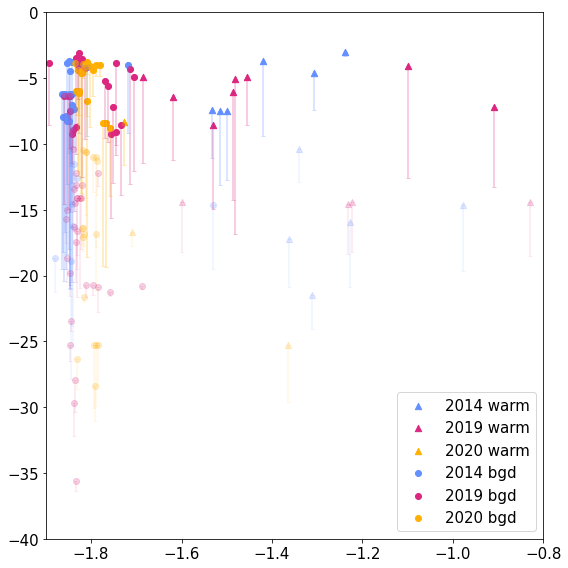

In [68]:
plt.figure(figsize=(8,8))

# 2014
plt.scatter(w2014nocloud[:,1],w2014nocloud[:,0],c = '#648FFF',marker = "^",label='2014 warm',s=40) 
plt.errorbar(w2014nocloud[:,1],w2014nocloud[:,0],yerr=[w2014nocloud[:,2], np.zeros_like(w2014nocloud[:,2])],fmt="^",capsize=2,alpha=0.3, color='#648FFF')

plt.scatter(w2014cloud[:,1],w2014cloud[:,0],c = '#648FFF',marker = "^",alpha=0.1,s=40) 
plt.errorbar(w2014cloud[:,1],w2014cloud[:,0],yerr=[w2014cloud[:,2], np.zeros_like(w2014cloud[:,2])],fmt="^",capsize=2,alpha=0.1,color = '#648FFF')

# 2019
plt.scatter(w2019nocloud[:,1],w2019nocloud[:,0],c = '#DC267F',marker = "^",label='2019 warm',s=40)
plt.errorbar(w2019nocloud[:,1],w2019nocloud[:,0],yerr=[w2019nocloud[:,2], np.zeros_like(w2019nocloud[:,2])],fmt="^",capsize=2,alpha=0.3, color= '#DC267F')

plt.scatter(w2019cloud[:,1],w2019cloud[:,0],c = '#DC267F',marker = "^",alpha=0.1,s=40)
plt.errorbar(w2019cloud[:,1],w2019cloud[:,0],yerr=[w2019cloud[:,2], np.zeros_like(w2019cloud[:,2])],fmt="^",capsize=2,alpha=0.1, color = '#DC267F')

# # 2020 
plt.scatter(w2020nocloud[:,1],w2020nocloud[:,0],c ='#FFB000',marker = "^",label='2020 warm',s=40)
plt.errorbar(w2020nocloud[:,1],w2020nocloud[:,0],yerr=[w2020nocloud[:,2], np.zeros_like(w2020nocloud[:,2])],fmt="^",capsize=2,alpha=0.3,color= '#FFB000')

plt.scatter(w2020cloud[:,1],w2020cloud[:,0],c = '#FFB000',marker = "^",alpha=0.1,s=40)
plt.errorbar(w2020cloud[:,1],w2020cloud[:,0],yerr=[w2020cloud[:,2], np.zeros_like(w2020cloud[:,2])],fmt="^",capsize=2,alpha=0.1,color = '#FFB000')

#plt.xlim(-0.8,-1.9);plt.ylim(0,-40)
plt.xlim(-1.9,-0.8);plt.ylim(-40,-0)
#plt.ylabel('MODIS temperature [C]');plt.xlabel('Seal-borne temperature [C]')

##
# 2014
plt.scatter(c2014nocloud[:,1],c2014nocloud[:,0],c = '#648FFF',label='2014 bgd') 
plt.errorbar(c2014nocloud[:,1],c2014nocloud[:,0],yerr=[c2014nocloud[:,2], np.zeros_like(c2014nocloud[:,2])],fmt="o",capsize=2,alpha=0.3, color= '#648FFF')

plt.scatter(c2014cloud[:,1],c2014cloud[:,0],c = '#648FFF',alpha=0.1) 
plt.errorbar(c2014cloud[:,1],c2014cloud[:,0],yerr=[c2014cloud[:,2], np.zeros_like(c2014cloud[:,2])],fmt="o",capsize=2,alpha=0.1,color = '#648FFF')

# 2019
plt.scatter(c2019nocloud[:,1],c2019nocloud[:,0],c = '#DC267F',label='2019 bgd')
plt.errorbar(c2019nocloud[:,1],c2019nocloud[:,0],yerr=[c2019nocloud[:,2], np.zeros_like(c2019nocloud[:,2])],fmt="o",capsize=2,alpha=0.3, color='#DC267F')

plt.scatter(c2019cloud[:,1],c2019cloud[:,0],c = '#DC267F',alpha=0.1)
plt.errorbar(c2019cloud[:,1],c2019cloud[:,0],yerr=[c2019cloud[:,2], np.zeros_like(c2019cloud[:,2])],fmt="o",capsize=2,alpha=0.1,color='#DC267F')

# # 2020 
plt.scatter(c2020nocloud[:,1],c2020nocloud[:,0],c = '#FFB000',label='2020 bgd')
plt.errorbar(c2020nocloud[:,1],c2020nocloud[:,0],yerr=[c2020nocloud[:,2], np.zeros_like(c2020nocloud[:,2])],fmt="o",capsize=2,alpha=0.3,color='#FFB000')

plt.scatter(c2020cloud[:,1],c2020cloud[:,0],c = '#FFB000',alpha=0.1)
plt.errorbar(c2020cloud[:,1],c2020cloud[:,0],yerr=[c2020cloud[:,2], np.zeros_like(c2020cloud[:,2])],fmt="o",capsize=2,alpha=0.1,color='#FFB000')

#plt.xlim(-0.8,-1.9);plt.ylim(0,-40)
plt.xlim(-1.9,-0.8);plt.ylim(-40,-0)
# plt.ylabel('MODIS temperature [C]',fontsize=13);plt.xlabel('Seal-borne temperature [C]',fontsize=13)

plt.legend(loc = 'lower right',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()

plt.savefig('fig8_A_updated.png', format='png', dpi=400)


#### Zoom into different temperature ranges (warm and background)

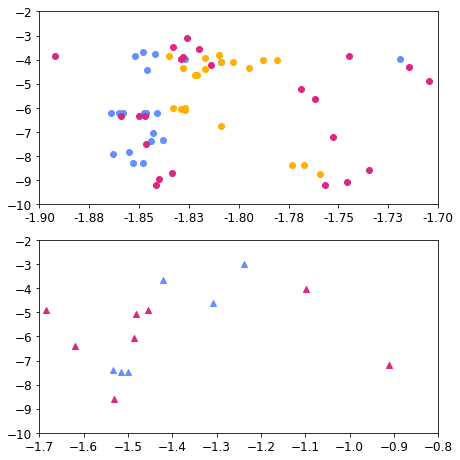

In [67]:
plt.figure(figsize=(6.5,6.5))

# 2014
plt.subplot(212)
plt.scatter(w2014nocloud[:,1],w2014nocloud[:,0],c = '#648FFF',marker = "^",label='2014 warm') 
plt.scatter(w2014cloud[:,1],w2014cloud[:,0],c = '#648FFF',marker = "^",alpha=0.1) 

# 2019
plt.scatter(w2019nocloud[:,1],w2019nocloud[:,0],c = '#DC267F',marker = "^",label='2019 warm')
plt.scatter(w2019cloud[:,1],w2019cloud[:,0],c = '#DC267F',marker = "^",alpha=0.1)

# # 2020 
plt.scatter(w2020nocloud[:,1],w2020nocloud[:,0],c ='#FFB000',marker = "^",label='2020 warm')
plt.scatter(w2020cloud[:,1],w2020cloud[:,0],c = '#FFB000',marker = "^",alpha=0.1)

plt.xlim(-1.7,-0.8);plt.ylim(-10,-2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

###
# 2014
plt.subplot(211)
plt.scatter(c2014nocloud[:,1],c2014nocloud[:,0],c = '#648FFF',label='2014 bgd') 
plt.scatter(c2014cloud[:,1],c2014cloud[:,0],c = '#648FFF',alpha=0.1) 

# 2019
plt.scatter(c2019nocloud[:,1],c2019nocloud[:,0],c = '#DC267F',label='2019 bgd')
plt.scatter(c2019cloud[:,1],c2019cloud[:,0],c = '#DC267F',alpha=0.1)

# # 2020 
plt.scatter(c2020nocloud[:,1],c2020nocloud[:,0],c = '#FFB000',label='2020 bgd')
plt.scatter(c2020cloud[:,1],c2020cloud[:,0],c = '#FFB000',alpha=0.1)

plt.xlim(-1.9,-1.7);plt.ylim(-10,-2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places


plt.tight_layout()

#plt.savefig('fig8_B&C_updated.png', format='png', dpi=400)

### 5. I save all panels and format for submission in illustrator or powerpoint :)

Screenshot of Fig. 8 from Savidge et al., 2023:

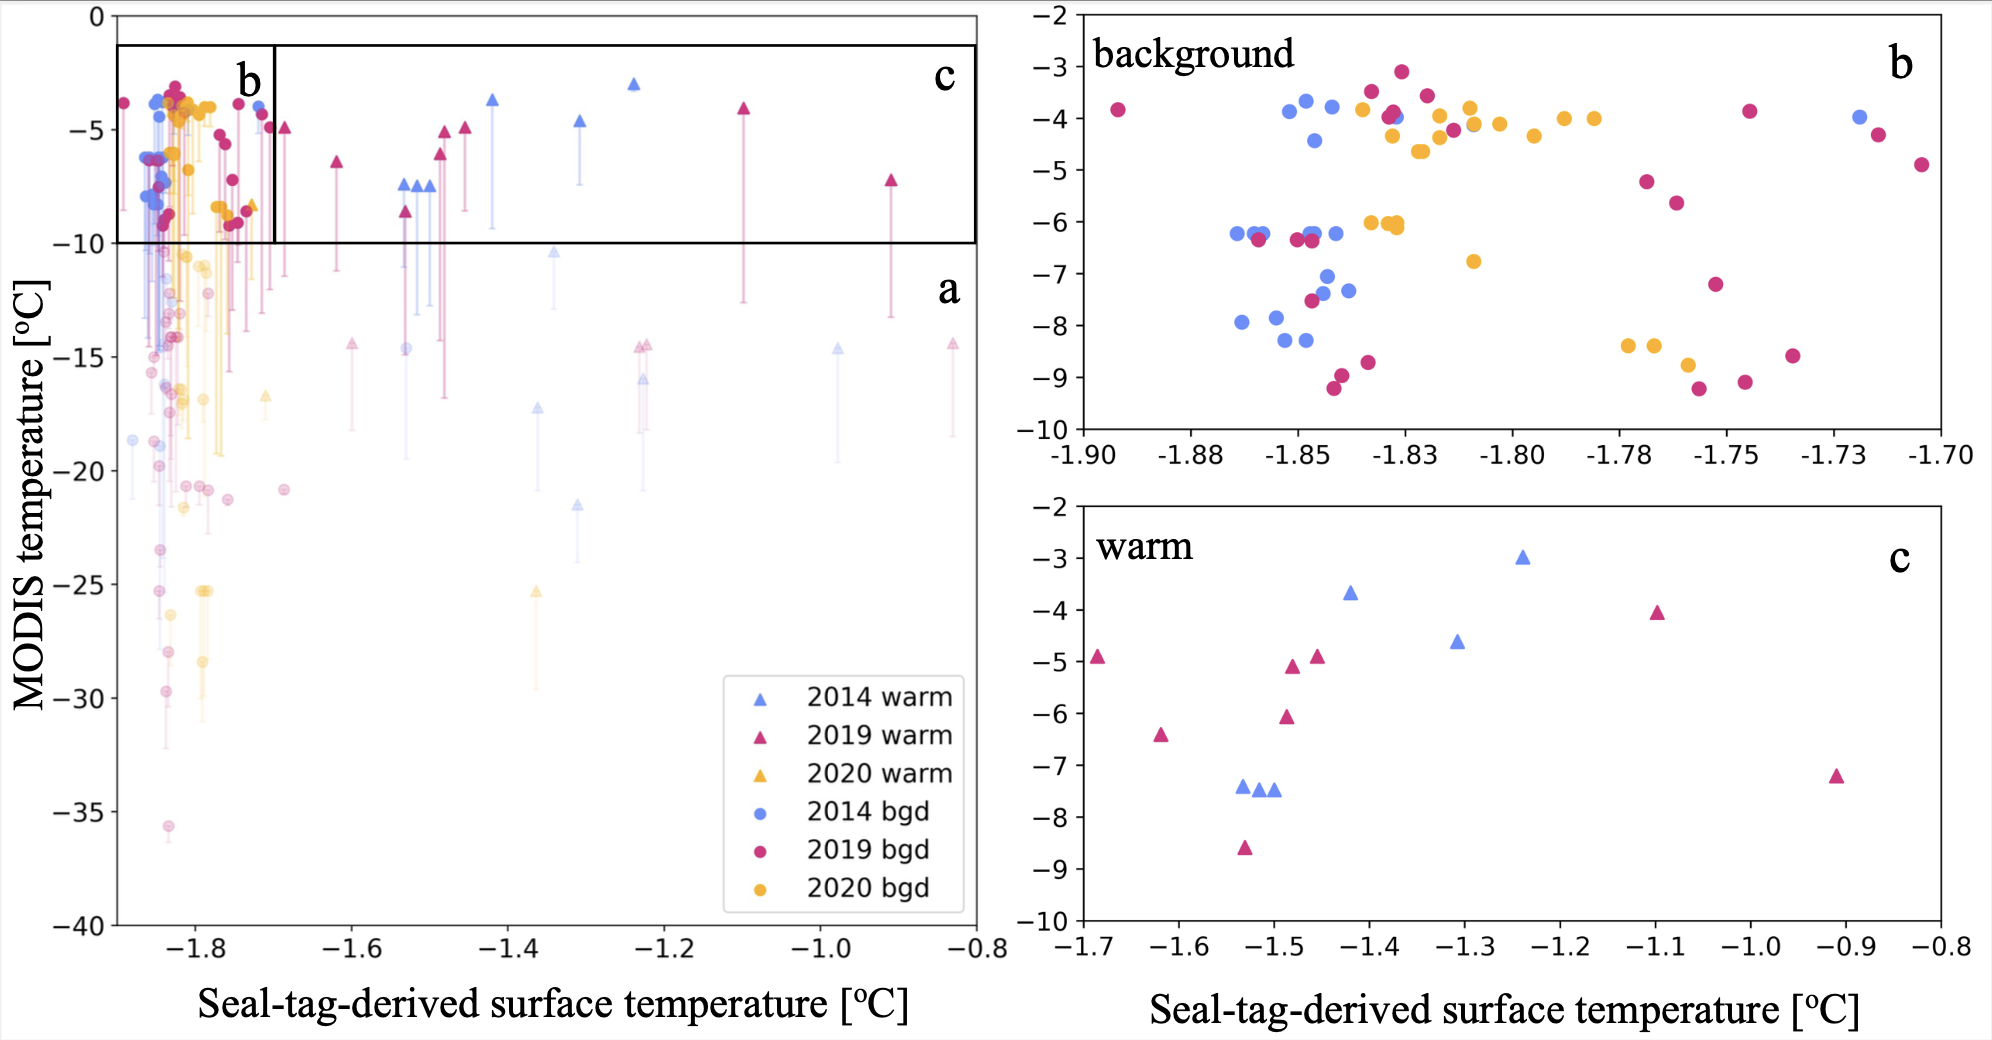

### ~ES